In [60]:
import pandas as pd
import numpy as np
import csv

# Load Student Info (Demographics) - Contains background like region; used for Language Friction.

df_info = pd.read_csv('studentInfo.csv')

# Load Assessments & Calculate Mean Score -Aggregating scores per student to get their average performance.

df_assess = pd.read_csv('studentAssessment.csv')

df_assess['score'] = pd.to_numeric(df_assess['score'], errors='coerce') # String error hatane ke liye fix:
student_scores = df_assess.groupby('id_student')['score'].mean().reset_index()

# Load VLE Data with Parser Fix - Using chunks to process 10M rows efficiently.

vle_chunks = pd.read_csv('studentVle.csv', chunksize=200000, engine='c', on_bad_lines='skip')

# Sampling 1000 students for performance
sample_ids = df_info['id_student'].sample(n=1000, random_state=42).tolist()

vle_list = []
for chunk in vle_chunks:
    filtered_chunk = chunk[chunk['id_student'].isin(sample_ids)]
    vle_list.append(filtered_chunk)

df_vle = pd.concat(vle_list)

# Aggregating VLE (Daily Engagement) - Summing clicks per student per day for time-series analysis.
df_vle_daily = df_vle.groupby(['id_student', 'date'])['sum_click'].sum().reset_index()

# Merging everything into a Master DataFrame - Clicks + Student Info
master_df = pd.merge(df_vle_daily, df_info[['id_student', 'region', 'highest_education', 'final_result']], on='id_student', how='left')

# dding the Marks (The part you requested) - Joining the calculated mean scores into the master table.
master_df = pd.merge(master_df, student_scores, on='id_student', how='left')

print(f"Total Rows: {len(master_df)}")
master_df.head()

Total Rows: 80513


,id_student,date,sum_click,region,highest_education,final_result,score
0,25572,-23,2,London Region,HE Qualification,Withdrawn,55.0
1,25572,-17,1,London Region,HE Qualification,Withdrawn,55.0
2,25572,-12,1,London Region,HE Qualification,Withdrawn,55.0
3,25572,-11,2,London Region,HE Qualification,Withdrawn,55.0
4,25572,-9,1,London Region,HE Qualification,Withdrawn,55.0


In [61]:
# 1. Language Friction Index (Proxy) - Assigning higher friction to students from regions potentially far from HQ.
native_regions = ['London Region', 'Scotland', 'Ireland', 'South Region']
master_df['lang_friction'] = master_df['region'].apply(lambda x: 0 if x in native_regions else 1)

# 2. Daily Fatigue Score (Rolling Average) - Fatigue is modeled as a rolling average of past clicks. Too many clicks = burnout.
master_df = master_df.sort_values(['id_student', 'date'])
master_df['fatigue_score'] = master_df.groupby('id_student')['sum_click'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 3. Normalization (from 0 to 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
master_df[['sum_click_norm', 'fatigue_norm']] = scaler.fit_transform(master_df[['sum_click', 'fatigue_score']])

master_df.head()

,id_student,date,sum_click,region,highest_education,final_result,score,lang_friction,fatigue_score,sum_click_norm,fatigue_norm
0,25572,-23,2,London Region,HE Qualification,Withdrawn,55.0,0,2.000000,0.000551,0.001302
1,25572,-17,1,London Region,HE Qualification,Withdrawn,55.0,0,1.500000,0.000000,0.000651
2,25572,-12,1,London Region,HE Qualification,Withdrawn,55.0,0,1.333333,0.000000,0.000434
3,25572,-11,2,London Region,HE Qualification,Withdrawn,55.0,0,1.333333,0.000551,0.000434
4,25572,-9,1,London Region,HE Qualification,Withdrawn,55.0,0,1.333333,0.000000,0.000434


In [3]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.7 MB/s eta 0:00:003.7 MB/s eta 0:00:01


In [66]:
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

# taking our students unique Id's
unique_students = master_df['id_student'].unique()

# 80% Train aur 20% Test mein divide karna - Splitting by students to maintain the sequence of dates for each student.
train_ids, test_ids = train_test_split(unique_students, test_size=0.2, random_state=42)

# filtering the Dataframes
train_df = master_df[master_df['id_student'].isin(train_ids)]
test_df = master_df[master_df['id_student'].isin(test_ids)]

#Training Set is ready
X_train = train_df[['sum_click_norm', 'fatigue_norm']].values
lengths_train = train_df.groupby('id_student').size().tolist()

# Testing Set is ready
X_test = test_df[['sum_click_norm', 'fatigue_norm']].values
lengths_test = test_df.groupby('id_student').size().tolist()

# Model Training
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100, random_state=42)
model.fit(X_train, lengths_train)

# ccuracy on Test Set -Since it's unsupervised, we use the score (Log-Likelihood) as our accuracy metric.
test_score = model.score(X_test, lengths_test)
train_score = model.score(X_train, lengths_train)

X_all = master_df[['sum_click_norm', 'fatigue_norm']].values
lengths_all = master_df.groupby('id_student').size().tolist()

# 4.creating column after predicting states: Using the trained model to predict and assign 'States' (0, 1, or 2) to each interaction.
master_df['predicted_state'] = model.predict(X_all, lengths_all)

print(f"Training : {train_score:.2f}")
print(f"Testing : {test_score:.2f}")


Model is not converging.  Current: 416030.6159926443 is not greater than 416030.9891353676. Delta is -0.3731427233433351


Training : 416029.39
Testing : 94798.43


In [73]:
def get_recommendation(state, friction):
    # State 2: High-Load 
    if state == 2:
        if friction == 1:
            return "Visual Summary Video (Native Language Subtitles)"
        else:
            return "Short Recap Video & Quiz"
            
    # State 1: Steady 
    elif state == 0: # Agar tumne State 0 ko Focused rakha hai
        if friction == 1:
            return "Simplified PDF Notes (Easy English)"
        else:
            return "Comprehensive Research Paper / Case Study"
            
    # State 0: At-Risk 
    else:
        return "Interactive Knowledge Check & Tutor Support"

# Ab apply karo (Axis=1 matlab row by row check karega)
master_df['recommendation'] = master_df.apply(lambda x: get_recommendation(x['predicted_state'], x['lang_friction']), axis=1)

master_df[['id_student', 'predicted_state', 'lang_friction', 'recommendation']].head()

,id_student,predicted_state,lang_friction,recommendation
0,25572,1,0,Interactive Knowledge Check & Tutor Support
1,25572,1,0,Interactive Knowledge Check & Tutor Support
2,25572,1,0,Interactive Knowledge Check & Tutor Support
3,25572,1,0,Interactive Knowledge Check & Tutor Support
4,25572,1,0,Interactive Knowledge Check & Tutor Support


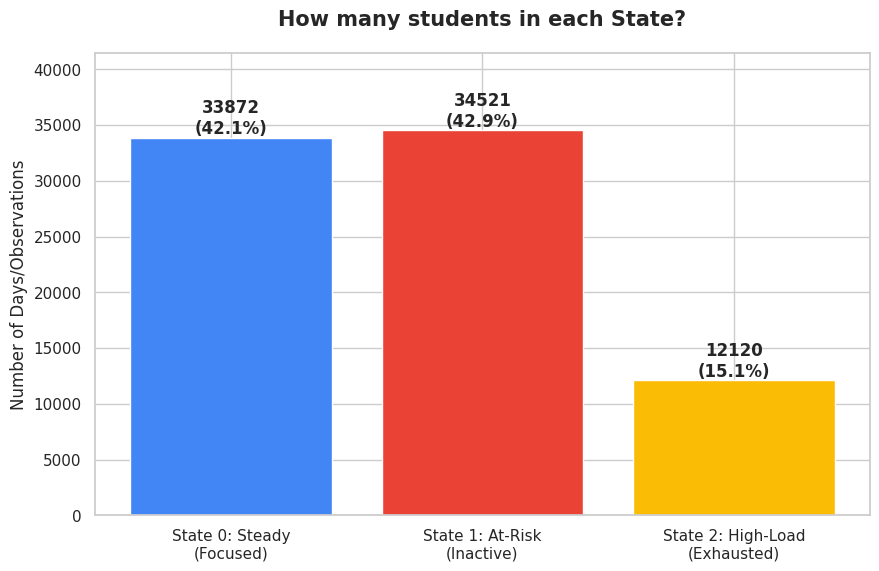

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pehle counts nikalte hain
state_counts = master_df['predicted_state'].value_counts().sort_index()
state_names = [
    'State 0: Steady\n(Focused)', 
    'State 1: At-Risk\n(Inactive)', 
    'State 2: High-Load\n(Exhausted)'
]

# 2. Graph Banana
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
bars = plt.bar(state_names, state_counts, color=['#4285F4', '#EA4335', '#FBBC05'])

# Labels lagana (Counts aur Percentage)
total = len(master_df)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('How many students in each State?', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Number of Days/Observations')
plt.ylim(0, max(state_counts) * 1.2) 
plt.show()

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  K-Means (X_train using which we used for HMM ) -n_clusters=3 taking to make it equal with HMM
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_train)

#  Testing Set (X_test) 
kmeans_test_labels = kmeans.predict(X_test)
# HMM pridiction from old model
hmm_test_labels = model.predict(X_test) 

score_kmeans = silhouette_score(X_test, kmeans_test_labels, sample_size=10000)
score_hmm = silhouette_score(X_test, hmm_test_labels, sample_size=10000)

print(f"K-Means Silhouette Score: {score_kmeans:.4f}")
print(f"HMM Silhouette Score: {score_hmm:.4f}")

K-Means Silhouette Score: 0.6475
HMM Silhouette Score: 0.3863


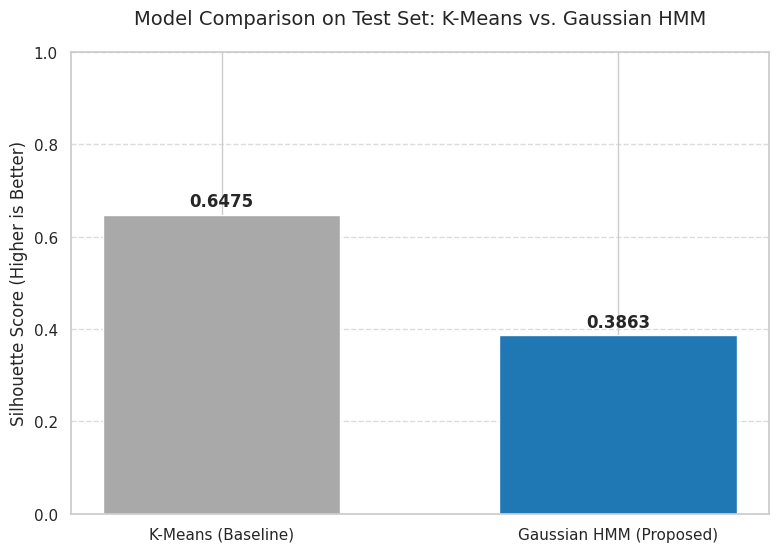

In [70]:
import matplotlib.pyplot as plt

# Comparison Data
models = ['K-Means (Baseline)', 'Gaussian HMM (Proposed)']
scores = [score_kmeans, score_hmm]


plt.figure(figsize=(9, 6))
bars = plt.bar(models, scores, color=['#A9A9A9', '#1f77b4'], width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.ylabel('Silhouette Score (Higher is Better)', fontsize=12)
plt.title('Model Comparison on Test Set: K-Means vs. Gaussian HMM', fontsize=14, pad=20)
plt.ylim(0, 1.0) # Silhouette score 0 se 1 ke beech hota hai
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()